<a href="https://colab.research.google.com/github/canamac/zeka-can/blob/main/DARALMA_S%C4%B0NYAL%C4%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

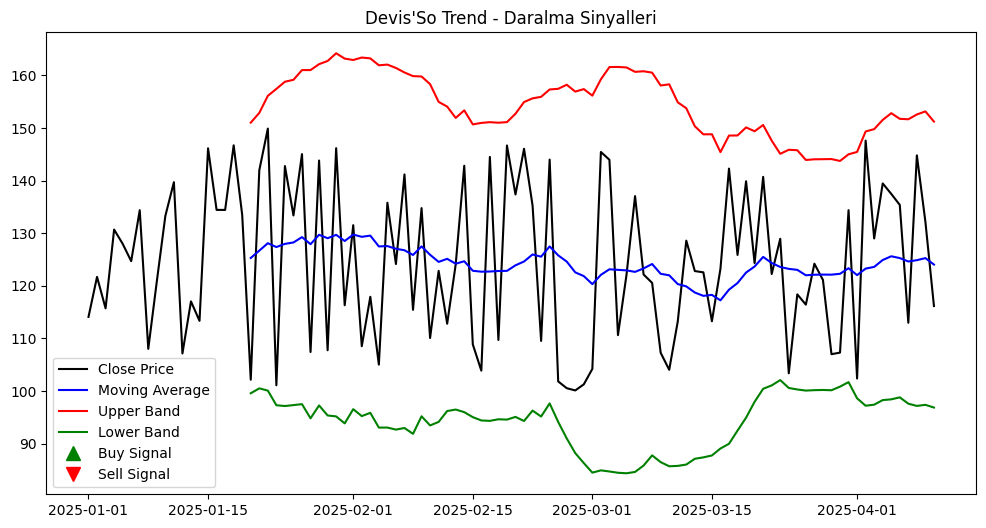

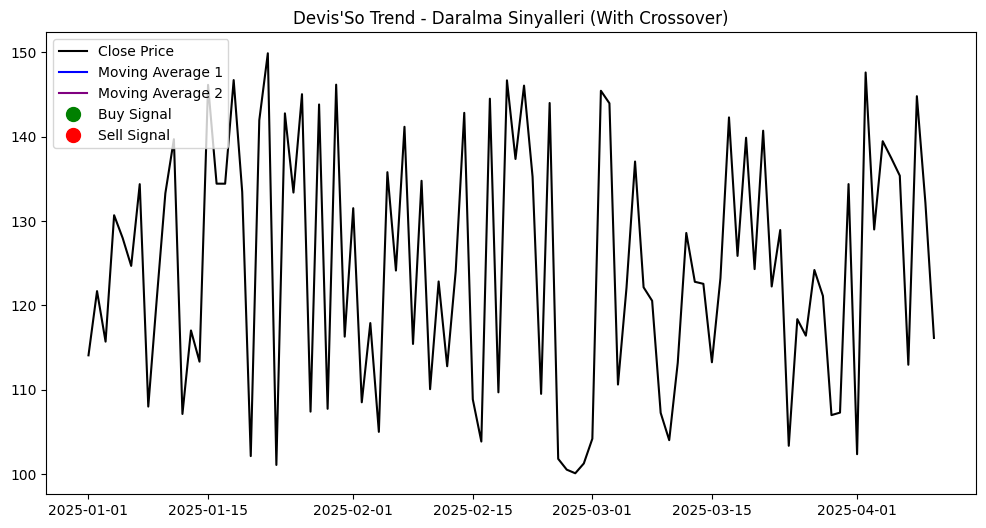

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate random sample OHLCV data for testing purposes
dates = pd.date_range('2025-01-01', periods=100, freq='D')
data = pd.DataFrame({
    'date': dates,
    'open': np.random.uniform(100, 150, 100),
    'high': np.random.uniform(150, 200, 100),
    'low': np.random.uniform(50, 100, 100),
    'close': np.random.uniform(100, 150, 100),
    'volume': np.random.randint(1000, 10000, 100)
})

# Set the 'date' column as the index
data.set_index('date', inplace=True)

# Define input parameters
zigzagHighPeriod = 10
zigzagLowPeriod = 10
minMovementPercent = 0.160
maPeriod = 20
stdDevMultiplier = 2.0
ma_length = 10
ma_volumelength = 7
daralmaEsik = 0.5

# Calculate minimum movement required for a signal
minMovement = data['close'] * minMovementPercent / 100

# Calculate Zigzag high and low values for the last X bars
data['zigzagHigh'] = np.where(data['high'].rolling(zigzagHighPeriod).apply(lambda x: x.argmax()) == 0, data['high'], np.nan)
data['zigzagLow'] = np.where(data['low'].rolling(zigzagLowPeriod).apply(lambda x: x.argmin()) == 0, data['low'], np.nan)

# Define Long Mumu and Short Mumu signals
LongMumu = (data['zigzagHigh'] > data['zigzagHigh'].shift(1)) & (data['close'] - data['close'].shift(1) >= minMovement)
ShortMumu = (data['zigzagLow'] < data['zigzagLow'].shift(1)) & (data['close'].shift(1) - data['close'] >= minMovement)

# Moving averages and standard deviations
data['ma'] = data['close'].rolling(maPeriod).mean()
data['upperBand'] = data['ma'] + stdDevMultiplier * data['close'].rolling(maPeriod).std()
data['lowerBand'] = data['ma'] - stdDevMultiplier * data['close'].rolling(maPeriod).std()

# Long and short signals with moving averages
longSignal = LongMumu & (data['close'] > data['ma']) & (data['close'] > data['upperBand'])
shortSignal = ShortMumu & (data['close'] < data['ma']) & (data['close'] < data['lowerBand'])

# Plot Moving Averages and Signals
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Close Price', color='black')
plt.plot(data['ma'], label='Moving Average', color='blue')
plt.plot(data['upperBand'], label='Upper Band', color='red')
plt.plot(data['lowerBand'], label='Lower Band', color='green')

# Plot buy and sell signals
plt.plot(data.index[longSignal], data['close'][longSignal], '^', markersize=10, color='green', label='Buy Signal')
plt.plot(data.index[shortSignal], data['close'][shortSignal], 'v', markersize=10, color='red', label='Sell Signal')

plt.title('Devis\'So Trend - Daralma Sinyalleri')
plt.legend()
plt.show()

# Daralma Condition (Moving averages convergence)
data['ma_allSignals'] = data['zigzagHigh'].fillna(data['zigzagLow']).rolling(ma_length).mean()
data['ma_allSignals2'] = data['zigzagLow'].fillna(data['zigzagHigh']).rolling(ma_length).mean()

# Check for convergence and plot shapes
daralmaKosulu = np.abs(data['ma_allSignals'] - data['ma_allSignals2']) < daralmaEsik

# Mark trades
longCrossover = data['close'] > data['ma_allSignals2']
shortCrossover = data['close'] < data['ma_allSignals2']

# Find trade signals based on the conditions
data['trade'] = np.where(longCrossover & daralmaKosulu, 'trade', np.where(shortCrossover & daralmaKosulu, 'trade', np.nan))

# Plot signals
plt.figure(figsize=(12, 6))
plt.plot(data['close'], label='Close Price', color='black')
plt.plot(data['ma_allSignals'], label='Moving Average 1', color='blue')
plt.plot(data['ma_allSignals2'], label='Moving Average 2', color='purple')
plt.plot(data.index[longCrossover & daralmaKosulu], data['close'][longCrossover & daralmaKosulu], 'o', markersize=10, color='green', label='Buy Signal')
plt.plot(data.index[shortCrossover & daralmaKosulu], data['close'][shortCrossover & daralmaKosulu], 'o', markersize=10, color='red', label='Sell Signal')

plt.title('Devis\'So Trend - Daralma Sinyalleri (With Crossover)')
plt.legend()
plt.show()
